# 1. Load data

In [59]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier

pd.options.mode.chained_assignment = None
sns.mpl.rc("figure", figsize=(15,8))

df_base = pd.read_csv('bank-classification.csv')

# Change type of results column
df_base.y.replace(('yes', 'no'), (1, 0), inplace=True)

# Transform strings into datetimes
df_base['birth_date'] = pd.to_datetime(df_base['birth_date'], format='%Y-%m-%d')
df_base['contact_date'] = pd.to_datetime(df_base['contact_date'], format='%Y-%m-%d')


# 2. Data visualization

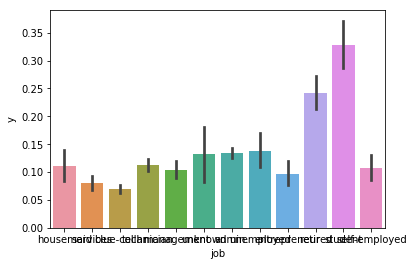

In [2]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

sns.barplot(x='job', y='y', data=learn)
plt.show()

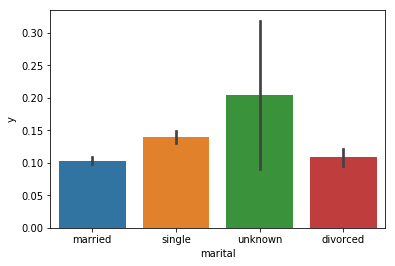

In [3]:
sns.barplot(x='marital', y='y', data=learn)
plt.show()

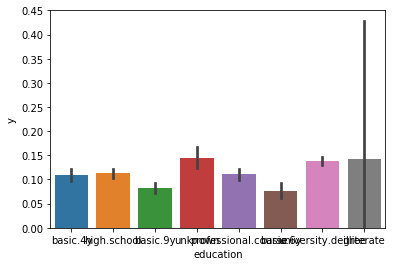

In [4]:
sns.barplot(x='education', y='y', data=learn)
plt.show()

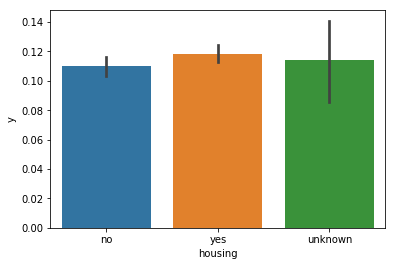

In [5]:
sns.barplot(x='housing', y='y', data=learn)
plt.show()

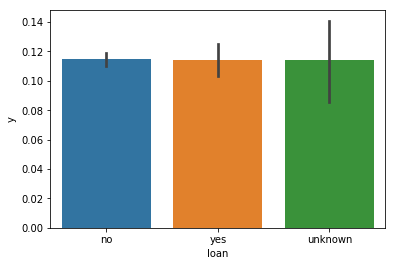

In [6]:
sns.barplot(x='loan', y='y', data=learn)
plt.show()

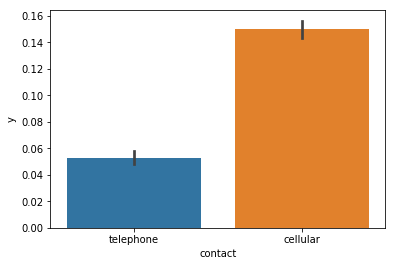

In [7]:
sns.barplot(x='contact', y='y', data=learn)
plt.show()

### Pdays - number of days that passed by after the client was last contacted from a previous campaign

Too big variances to not combine one hot features

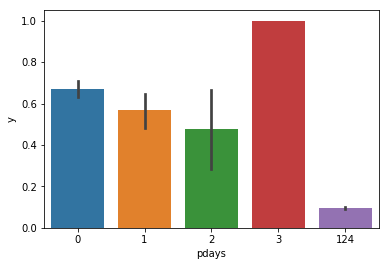

In [8]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['pdays'] = learn['pdays'].apply(lambda x: x/8)
sns.barplot(x='pdays', y='y', data=learn)
plt.show()

### Campaign - number of contacts performed during this campaign and for this client (numeric, includes last contact)

Higher-number days have too big variance, so it seems to be reasonable to combine them into common features. So we will use categoties: first 0-3, 4-7, 8-11, 12-... calls

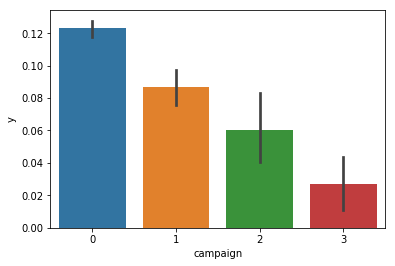

In [9]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['campaign'] = learn['campaign'].apply(lambda x: x/4)
learn.loc[learn.campaign > 2, 'campaign'] = 3

sns.barplot(x='campaign', y='y', data=learn)


plt.show()

### Contact_date

Contact date, when splitted in 6-month periods, looks like great feature. Quite big differences between periods and low deviation.

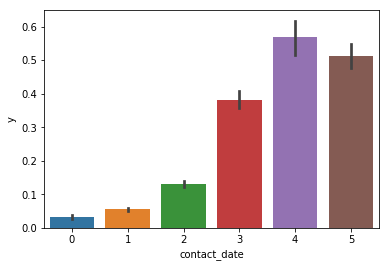

In [10]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['contact_date'] = learn['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/6)
sns.barplot(x='contact_date', y='y', data=learn)
plt.show()

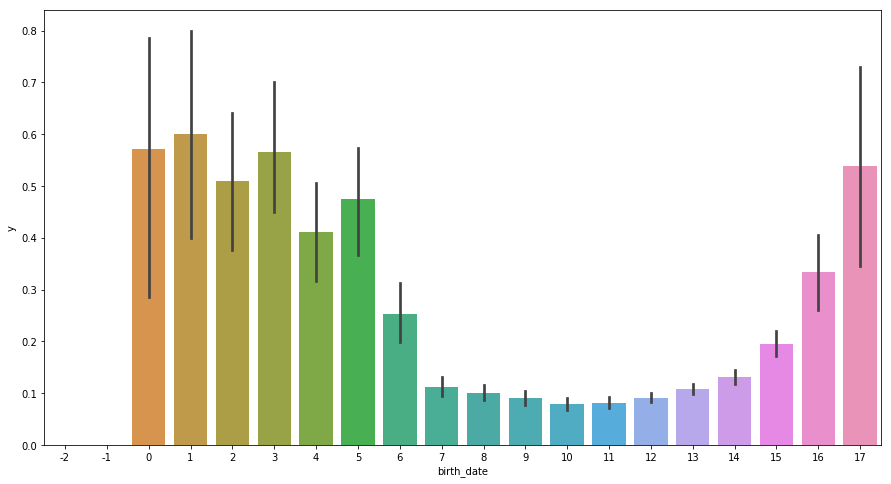

In [48]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['birth_date'] = learn['birth_date'].apply(lambda x: (x.month + (x.year-1920)*12)/50)
sns.barplot(x='birth_date', y='y', data=learn)
plt.show()

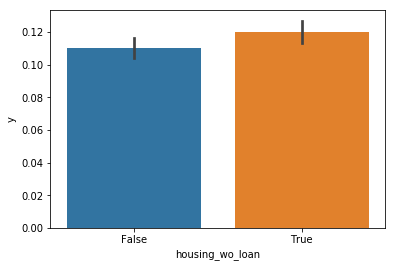

In [11]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['housing_wo_loan'] = learn.apply(lambda x: x['housing']=='yes' and x['loan']=='no', axis=1)

sns.barplot(x='housing_wo_loan', y='y', data=learn)
plt.show()

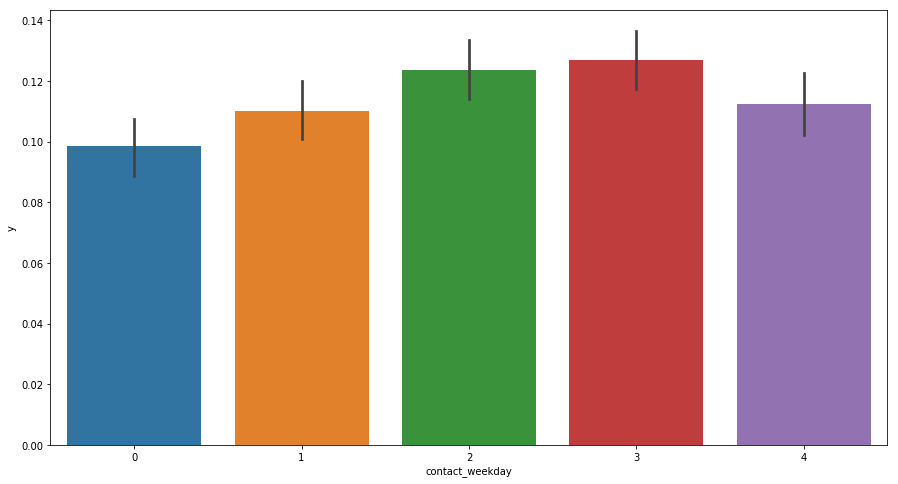

In [18]:
df = df_base.copy()
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['contact_weekday'] = learn['contact_date'].apply(lambda x: x.weekday())

sns.barplot(x='contact_weekday', y='y', data=learn)
plt.show()

# 3. Feature engineering

In [70]:
df = df_base.copy()

df['housing_wo_loan'] = df.apply(lambda x: x['housing']=='yes' and x['loan']=='no', axis=1)
df['contact_weekday'] = df['contact_date'].apply(lambda x: x.weekday())

# Drop month and day of birth
#df['birth_date'] = df['birth_date'].apply(lambda x: x.split('-')[0])
df['birth_date'] = df['birth_date'].apply(lambda x: (x.month + (x.year-1920)*12)/50)

# Split contact_date into 6-month periods
df['contact_weekday'] = df['contact_date'].apply(lambda x: x.weekday())
df['contact_date'] = df['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/6)

df['pdays'] = df['pdays'].apply(lambda x: x/8)
df['campaign'] = df['campaign'].apply(lambda x: x/4)

df['campaign'] = df['campaign'].apply(lambda x: x/4)
df.loc[df.campaign > 2, 'campaign'] = 3

df.contact.replace(('cellular', 'telephone'), (1, 0), inplace=True)

one_hot_columns = ['marital', 'education', 'default', 'poutcome', 'job', 'pdays', 'housing', 'loan']
df = pd.get_dummies(df, columns=one_hot_columns)

print df.dtypes

len(df)

id                                int64
birth_date                        int64
contact_date                      int64
contact                           int64
campaign                          int64
previous                          int64
y                                object
housing_wo_loan                    bool
contact_weekday                   int64
marital_divorced                  uint8
marital_married                   uint8
marital_single                    uint8
marital_unknown                   uint8
education_basic.4y                uint8
education_basic.6y                uint8
education_basic.9y                uint8
education_high.school             uint8
education_illiterate              uint8
education_professional.course     uint8
education_university.degree       uint8
education_unknown                 uint8
default_no                        uint8
default_unknown                   uint8
default_yes                       uint8
poutcome_failure                  uint8


41188

# 4. Learning

In [71]:
# Split data into learning and testing rows
learn = df.loc[df['y'] != 'unknown']
test = df.loc[df['y'] == 'unknown']
learn = shuffle(learn)

learn['y'] = learn['y'].astype('int64')

#predicators = ['contact_cellular', 'contact_telephone', 'poutcome_success', 'poutcome_nonexistent', 'poutcome_nonexistent', 'loan_no', 'loan_yes', 'loan_unknown', 'housing_unknown', 'housing_yes', 'housing_no', 'previous', 'default_no', 'default_yes', 'default_unknown']
predictors = [x for x in learn.columns if x not in ['y']]
params_ranges = {'n_estimators': [40, 200],
                 'min_samples_split': [150, 500],
                 'min_samples_leaf': [50, 100],
                 'max_depth': [5, 8],
                 'subsample': [0.5, 0.9]}

classifier = GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt', random_state=13)
gsearch = RandomizedSearchCV(estimator = classifier, param_distributions=params_ranges, scoring='roc_auc', n_jobs=8, iid=False, cv=5)

gsearch.fit(learn[predictors], learn['y'])

print gsearch.best_params_, gsearch.best_score_


{'n_estimators': 200, 'subsample': 0.9, 'min_samples_split': 150, 'max_depth': 8, 'min_samples_leaf': 50} 0.791109858459


In [72]:
dtrain_predictions = gsearch.predict(learn[predictors])
cv_score = model_selection.cross_val_score(gsearch, learn[predictors], learn['y'], cv=10, scoring='roc_auc')
dtrain_predprob = gsearch.predict_proba(learn[predictors])[:,1]

In [73]:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(learn['y'].values, dtrain_predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(learn['y'], dtrain_predprob)
print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))


Model Report
Accuracy : 0.9085
AUC Score (Train): 0.862015
CV Score : Mean - 0.7893036 | Std - 0.02644567 | Min - 0.7376276 | Max - 0.8326616


# 5. Predict

In [74]:
test = df.loc[df['y'] == 'unknown']
results = gsearch.predict_proba(test[predictors])
test['y'] = results
test[['id', 'y']].to_csv("results.csv", encoding='utf-8', index=False)

In [80]:
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators':range(35,45,1)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(learn[predictors],learn['y'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [35, 36, 37, 38, 39, 40, 41, 42, 43, 44]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [81]:
print gsearch1.best_params_, gsearch1.best_score_

{'n_estimators': 36} 0.791294997869


In [83]:
train = learn
target = 'y'
param_test2 = {'max_depth':range(13,16,1), 'min_samples_split':range(200,1001,100)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=36, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/hubert/Documents/jnp3/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79006, std: 0.01346, params: {'min_samples_split': 200, 'max_depth': 13},
  mean: 0.78927, std: 0.01727, params: {'min_samples_split': 300, 'max_depth': 13},
  mean: 0.79105, std: 0.01379, params: {'min_samples_split': 400, 'max_depth': 13},
  mean: 0.78970, std: 0.01456, params: {'min_samples_split': 500, 'max_depth': 13},
  mean: 0.79170, std: 0.01587, params: {'min_samples_split': 600, 'max_depth': 13},
  mean: 0.79245, std: 0.01601, params: {'min_samples_split': 700, 'max_depth': 13},
  mean: 0.79143, std: 0.01793, params: {'min_samples_split': 800, 'max_depth': 13},
  mean: 0.79388, std: 0.01408, params: {'min_samples_split': 900, 'max_depth': 13},
  mean: 0.79360, std: 0.01477, params: {'min_samples_split': 1000, 'max_depth': 13},
  mean: 0.78774, std: 0.01349, params: {'min_samples_split': 200, 'max_depth': 14},
  mean: 0.78862, std: 0.01560, params: {'min_samples_split': 300, 'max_depth': 14},
  mean: 0.78928, std: 0.01404, params: {'min_samples_split': 400, 'max_dept

In [85]:
param_test3 = {'min_samples_split':range(1000,2100,100), 'min_samples_leaf':range(10,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=36, max_depth=15, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc', n_jobs=8, cv=10)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/hubert/Documents/jnp3/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.78999, std: 0.02673, params: {'min_samples_split': 1000, 'min_samples_leaf': 10},
  mean: 0.79066, std: 0.02707, params: {'min_samples_split': 1100, 'min_samples_leaf': 10},
  mean: 0.79035, std: 0.02534, params: {'min_samples_split': 1200, 'min_samples_leaf': 10},
  mean: 0.79070, std: 0.02692, params: {'min_samples_split': 1300, 'min_samples_leaf': 10},
  mean: 0.78910, std: 0.02676, params: {'min_samples_split': 1400, 'min_samples_leaf': 10},
  mean: 0.79205, std: 0.02941, params: {'min_samples_split': 1500, 'min_samples_leaf': 10},
  mean: 0.79026, std: 0.02714, params: {'min_samples_split': 1600, 'min_samples_leaf': 10},
  mean: 0.79100, std: 0.02838, params: {'min_samples_split': 1700, 'min_samples_leaf': 10},
  mean: 0.78967, std: 0.02727, params: {'min_samples_split': 1800, 'min_samples_leaf': 10},
  mean: 0.78937, std: 0.02809, params: {'min_samples_split': 1900, 'min_samples_leaf': 10},
  mean: 0.78987, std: 0.02975, params: {'min_samples_split': 2000, 'min_samples_

In [87]:
param_test4 = {'max_features':range(15,25,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=36,max_depth=15, min_samples_split=1400, min_samples_leaf=40, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=8,iid=False, cv=10)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/hubert/Documents/jnp3/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79261, std: 0.02662, params: {'max_features': 7},
  mean: 0.79041, std: 0.02685, params: {'max_features': 8},
  mean: 0.79201, std: 0.02795, params: {'max_features': 9},
  mean: 0.79160, std: 0.02679, params: {'max_features': 10},
  mean: 0.79285, std: 0.02582, params: {'max_features': 11},
  mean: 0.79251, std: 0.02658, params: {'max_features': 12},
  mean: 0.79238, std: 0.02474, params: {'max_features': 13},
  mean: 0.79480, std: 0.02601, params: {'max_features': 14},
  mean: 0.79455, std: 0.02475, params: {'max_features': 15},
  mean: 0.79443, std: 0.02681, params: {'max_features': 16},
  mean: 0.79308, std: 0.02434, params: {'max_features': 17},
  mean: 0.79377, std: 0.02669, params: {'max_features': 18},
  mean: 0.79484, std: 0.02614, params: {'max_features': 19}],
 {'max_features': 19},
 0.79483989989401838)

In [109]:
param_test5 = {'subsample':[0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=70,max_depth=15,min_samples_split=1400, min_samples_leaf=40, random_state=10,max_features=19),
param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/hubert/Documents/jnp3/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79551, std: 0.02664, params: {'subsample': 0.81},
  mean: 0.79470, std: 0.02506, params: {'subsample': 0.82},
  mean: 0.79608, std: 0.02629, params: {'subsample': 0.83},
  mean: 0.79550, std: 0.02532, params: {'subsample': 0.84},
  mean: 0.79684, std: 0.02606, params: {'subsample': 0.85},
  mean: 0.79646, std: 0.02564, params: {'subsample': 0.86},
  mean: 0.79554, std: 0.02494, params: {'subsample': 0.87},
  mean: 0.79568, std: 0.02516, params: {'subsample': 0.88},
  mean: 0.79567, std: 0.02629, params: {'subsample': 0.89},
  mean: 0.79480, std: 0.02605, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 0.79684004055790569)

In [110]:
test = df.loc[df['y'] == 'unknown']
results = gsearch5.predict_proba(test[predictors])
test['y'] = results
test[['id', 'y']].to_csv("results.csv", encoding='utf-8', index=False)